In [1]:
import numpy as np
from geometricus import GeometricusEmbedding, MomentType, MomentInvariants
import prody as pd
from umap import UMAP
from pathlib import Path
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import networkx as nx
from cath_utils import cath
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2


In [2]:
pdb_folder = "./cath_data/dompdb/"
invariants = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
                                        size=30)
single_invariant = invariants[list(invariants.keys())[0]]

invariants2 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.RADIUS_UPSAMPLE,
                                              size=10)
invariants = {k: cath.concat_invariants(v, invariants2[k]) for k, v in invariants.items()}
print("invariants extracted")


invariants extracted


In [9]:
domain_info = cath.DomainInfo.from_domainlist_file("./cath_data/cath-domain-list-S100.txt").domains
cath_mapping = {k: f"{v.c_class}-{v.architecture}-{v.topology}" for k, v in domain_info.items() if k in invariants}

keys, counts = np.unique(list(cath_mapping.values()), return_counts=True)
least_allowed_class_count = 20
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
cath_mapping = {k: v for k, v in cath_mapping.items() if v in keys_to_use}
print("cath info linked to files")
len(keys_to_use)

cath info linked to files


116

In [13]:
del train_data, test_data
torch.cuda.empty_cache()
train_data, test_data = cath.transform_geometricus_dataset_for_training(cath_mapping,
                                                                   invariants, batch_no=512)

In [14]:
torch.cuda.empty_cache()

In [15]:
model = cath.train_model(
    train_data,
    test_data,
    number_of_node_features=single_invariant.moments.shape[1],
    hidden_channels=128,
    number_of_classes=len(keys_to_use),
    lr=0.0002,
    epochs=5000,
)

Initial: Train Acc: 0.0109, Test Acc: 0.0109
Epoch: 010, Train Acc: 0.1743, Test Acc: 0.1732
Epoch: 020, Train Acc: 0.2605, Test Acc: 0.2520
Epoch: 030, Train Acc: 0.2769, Test Acc: 0.2676
Epoch: 040, Train Acc: 0.2843, Test Acc: 0.2771
Epoch: 050, Train Acc: 0.2981, Test Acc: 0.2900
Epoch: 060, Train Acc: 0.3082, Test Acc: 0.3018
Epoch: 070, Train Acc: 0.3199, Test Acc: 0.3112
Epoch: 080, Train Acc: 0.3288, Test Acc: 0.3190
Epoch: 090, Train Acc: 0.3329, Test Acc: 0.3238
Epoch: 100, Train Acc: 0.3356, Test Acc: 0.3277
Epoch: 110, Train Acc: 0.3426, Test Acc: 0.3325
Epoch: 120, Train Acc: 0.3470, Test Acc: 0.3360
Epoch: 130, Train Acc: 0.3497, Test Acc: 0.3389
Epoch: 140, Train Acc: 0.3547, Test Acc: 0.3429
Epoch: 150, Train Acc: 0.3565, Test Acc: 0.3422
Epoch: 160, Train Acc: 0.3629, Test Acc: 0.3502
Epoch: 170, Train Acc: 0.3673, Test Acc: 0.3536
Epoch: 180, Train Acc: 0.3673, Test Acc: 0.3551
Epoch: 190, Train Acc: 0.3657, Test Acc: 0.3525
Epoch: 200, Train Acc: 0.3725, Test Acc: 0.

Epoch: 1700, Train Acc: 0.6008, Test Acc: 0.5461
Epoch: 1710, Train Acc: 0.5991, Test Acc: 0.5442
Epoch: 1720, Train Acc: 0.6033, Test Acc: 0.5472
Epoch: 1730, Train Acc: 0.6009, Test Acc: 0.5440
Epoch: 1740, Train Acc: 0.5914, Test Acc: 0.5407
Epoch: 1750, Train Acc: 0.5954, Test Acc: 0.5401
Epoch: 1760, Train Acc: 0.6039, Test Acc: 0.5463
Epoch: 1770, Train Acc: 0.6047, Test Acc: 0.5456
Epoch: 1780, Train Acc: 0.6050, Test Acc: 0.5466
Epoch: 1790, Train Acc: 0.6060, Test Acc: 0.5460
Epoch: 1800, Train Acc: 0.6080, Test Acc: 0.5489
Epoch: 1810, Train Acc: 0.6092, Test Acc: 0.5505
Epoch: 1820, Train Acc: 0.6106, Test Acc: 0.5484
Epoch: 1830, Train Acc: 0.6107, Test Acc: 0.5498
Epoch: 1840, Train Acc: 0.6062, Test Acc: 0.5463
Epoch: 1850, Train Acc: 0.6120, Test Acc: 0.5515
Epoch: 1860, Train Acc: 0.6115, Test Acc: 0.5503
Epoch: 1870, Train Acc: 0.6139, Test Acc: 0.5499
Epoch: 1880, Train Acc: 0.6144, Test Acc: 0.5511
Epoch: 1890, Train Acc: 0.6171, Test Acc: 0.5542
Epoch: 1900, Train A

KeyboardInterrupt: 

In [1]:
torch.save(model, "embedder2.pth")

NameError: name 'torch' is not defined

In [101]:
def get_embedding(loaders):
    model.eval()
    res = list()
    labels = []
    predicted_labels = []
    for loader in loaders:
        for data in loader:
            data = data.cuda()
            out = model(data.x, data.edge_index, data.batch)
            res.append(out.cpu().detach().numpy())
            labels.append(data.y.reshape(out.shape[0], -1).argmax(dim=1).cpu().detach().numpy())
            predicted_labels.append(out.argmax(dim=1).cpu().detach().numpy())
    return np.concatenate(res), np.concatenate(labels), np.concatenate(predicted_labels)

In [102]:
import umap

In [115]:
pytorch_embedding, labels, pred = get_embedding([train_data, test_data])
pytorch_embedding.shape, labels.shape, pred.shape

((14940, 116), (14940,), (14940,))

In [109]:
torch.cuda.empty_cache()

In [116]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

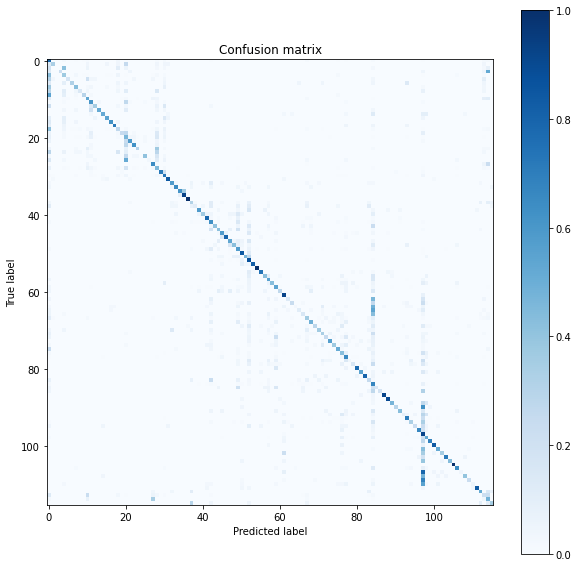

In [92]:
from sklearn.metrics import confusion_matrix
import itertools

confusionMatrix = confusion_matrix(labels, pred)

confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


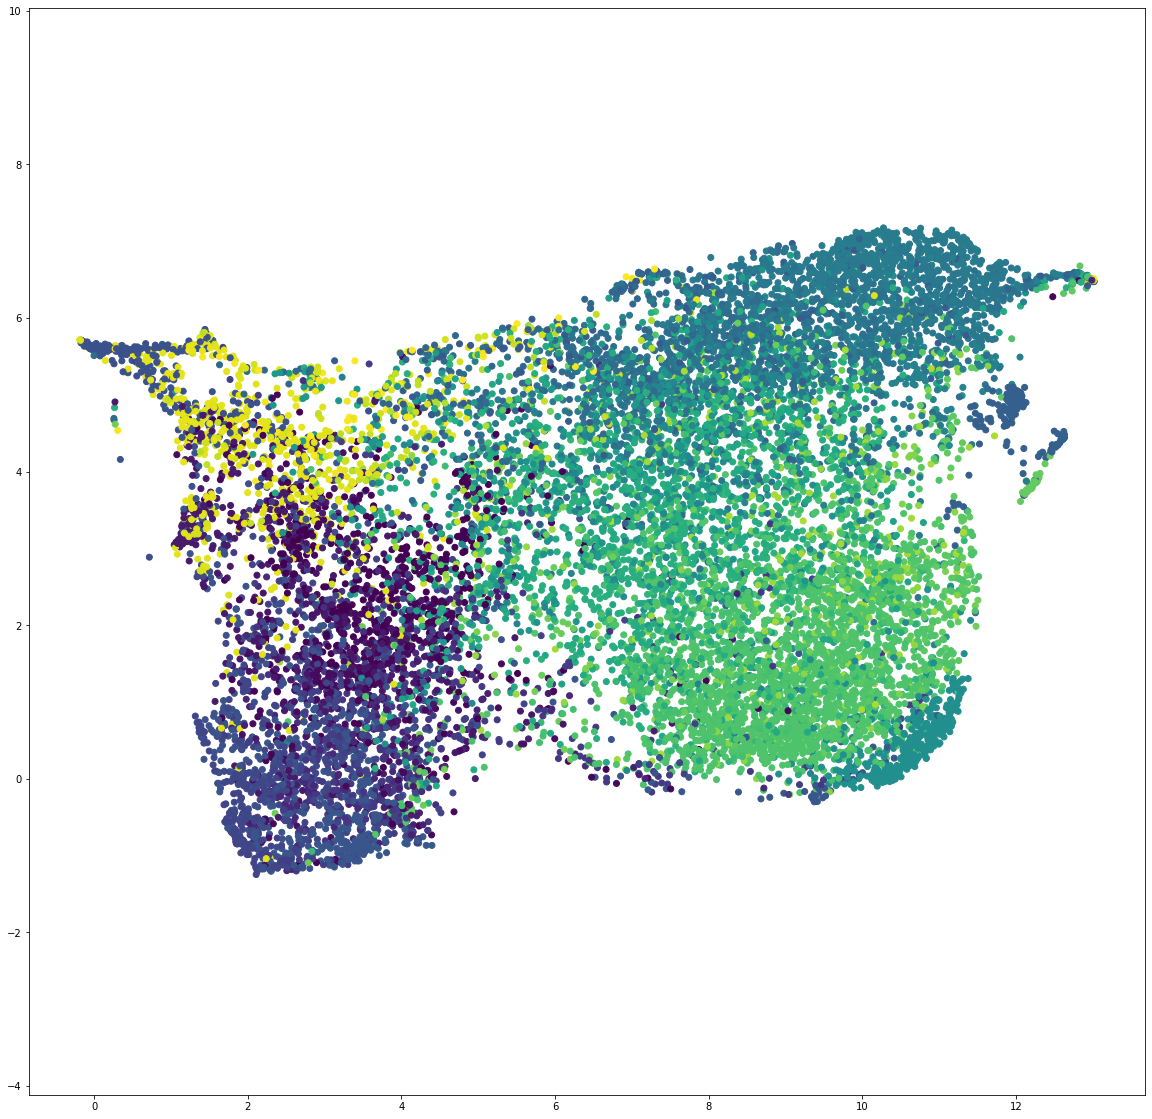

In [117]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [ ]:
domain_info = cath.DomainInfo.from_domainlist_file("./cath_data/cath-domain-list-S100.txt").domains
cath_mapping = {k: f"{v.c_class}-{v.architecture}-{v.topology}" for k, v in domain_info.items() if k in invariants}

keys, counts = np.unique(list(cath_mapping.values()), return_counts=True)
least_allowed_class_count = 10_000
keys_to_use = {x for x in keys[np.where(counts <= least_allowed_class_count)[0]]}
cath_mapping = {k: v for k, v in cath_mapping.items() if v in keys_to_use}
print("cath info linked to files")
len(keys_to_use)


In [ ]:
del train_data, test_data
torch.cuda.empty_cache()
train_data, test_data = cath.transform_geometricus_dataset_for_training(cath_mapping,
                                                                   invariants, batch_no=512)

reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

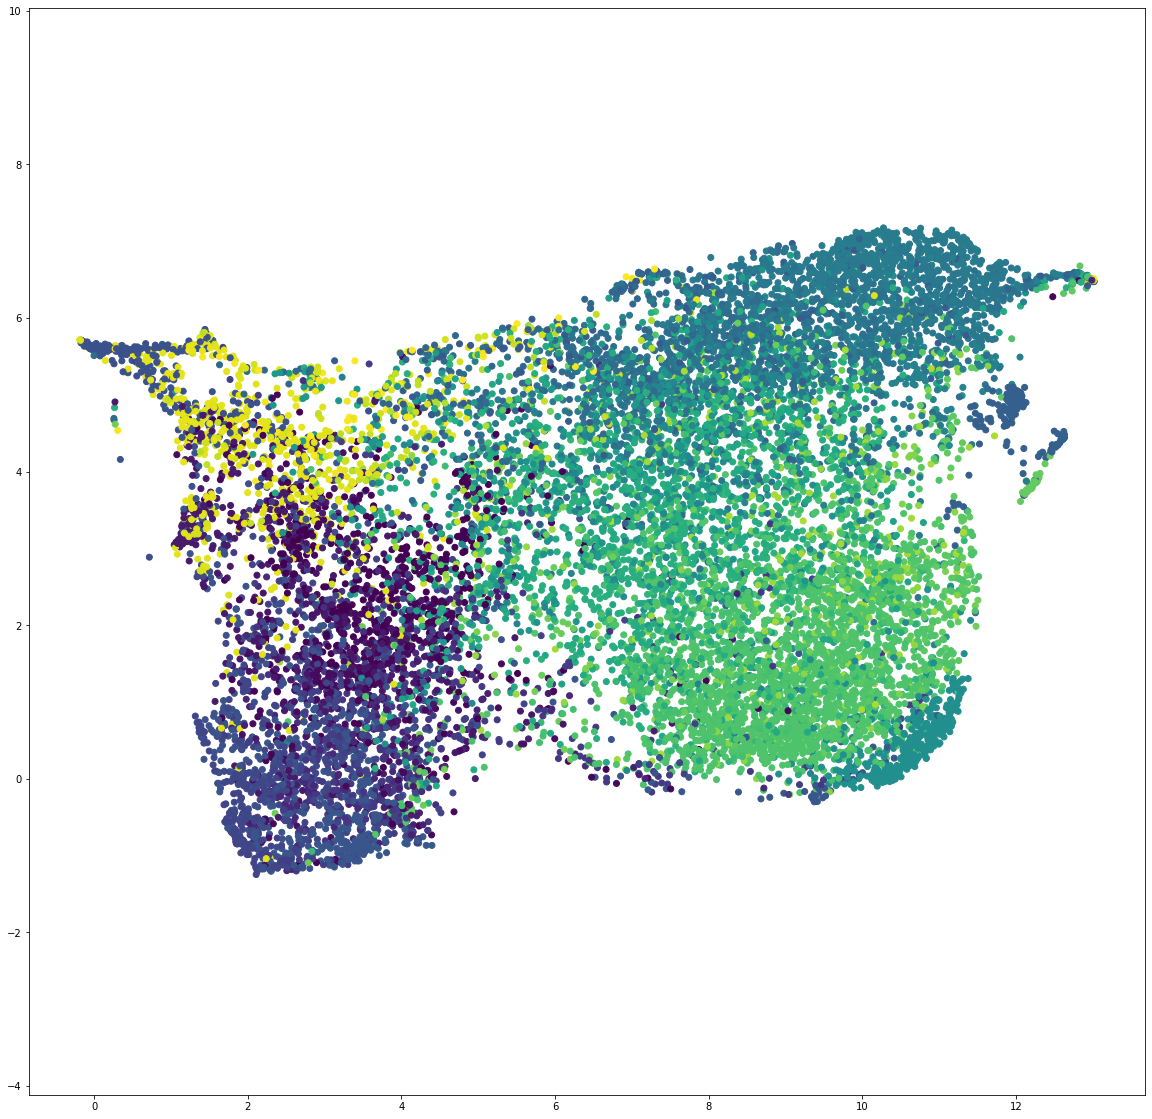

In [119]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [1]:
import pickle
iv = pickle.load(open("ecod_invariants.pkl", "rb"))